In [46]:
# basic
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
import matplotlib.pyplot as plt

# textual processing
import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# modeling
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.svm import SVC

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit

from keras.utils import to_categorical
from keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

### Load Data

In [242]:
joined_df = pd.read_csv('joined_final.csv')

In [243]:
joined_df.head()

,term,course,type_x,num_reviewers,num_students,rAmountLearned,rCommAbility,rCourseQuality,rDifficulty,rInstructorAccess,...,SHDH,VANC,rCourseQualityBinned,0,1,0.1,1.1,2,3,4
0,2010a,ACCT-101-401,LEC,62,70,2.93,2.82,2.60,2.65,3.08,...,0,0,2,1,0,1,0,0,0,0
1,2010a,ACCT-101-402,LEC,73,75,2.89,2.82,2.49,3.05,2.96,...,0,0,2,1,0,1,0,0,0,0
2,2010a,ACCT-101-403,LEC,82,83,2.88,2.80,2.63,2.84,3.03,...,0,0,2,1,0,1,0,0,0,0
3,2010a,ACCT-101-410,REC,32,35,2.19,2.35,2.14,2.56,2.19,...,0,0,2,1,0,1,0,0,0,0
4,2010a,ACCT-101-411,REC,34,37,2.65,2.64,2.09,2.61,2.48,...,0,0,2,1,0,1,0,0,0,0


In [246]:
len(joined_df)

2601

In [245]:
joined_df = joined_df.dropna(subset=['rCourseQuality', 'gender', 'race'])

In [247]:
joined_df['rCourseQualityBinned'] = joined_df['rCourseQuality'].astype(int)

In [249]:
joined_df.columns.values[56] = "Female"
joined_df.columns.values[55] = "Male"
joined_df.columns.values[54] = "Others"
joined_df.columns.values[53] = "Indian"
joined_df.columns.values[52] = "Asian"
joined_df.columns.values[51] = "Black"
joined_df.columns.values[50] = "White"

In [250]:
joined_df.head()

,term,course,type_x,num_reviewers,num_students,rAmountLearned,rCommAbility,rCourseQuality,rDifficulty,rInstructorAccess,...,SHDH,VANC,rCourseQualityBinned,White,Black,Asian,Indian,Others,Male,Female
0,2010a,ACCT-101-401,LEC,62,70,2.93,2.82,2.60,2.65,3.08,...,0,0,2,1,0,1,0,0,0,0
1,2010a,ACCT-101-402,LEC,73,75,2.89,2.82,2.49,3.05,2.96,...,0,0,2,1,0,1,0,0,0,0
2,2010a,ACCT-101-403,LEC,82,83,2.88,2.80,2.63,2.84,3.03,...,0,0,2,1,0,1,0,0,0,0
3,2010a,ACCT-101-410,REC,32,35,2.19,2.35,2.14,2.56,2.19,...,0,0,2,1,0,1,0,0,0,0
4,2010a,ACCT-101-411,REC,34,37,2.65,2.64,2.09,2.61,2.48,...,0,0,2,1,0,1,0,0,0,0


In [252]:
joined_df.to_csv('joined_for_dtm.csv')

### Textual Analysis Cleaning

In [17]:
joined = pd.read_csv('complete_with_words.csv')

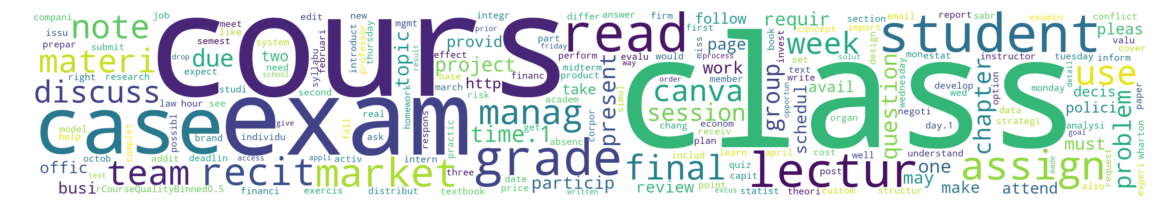

In [500]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(width=2000, height=500,background_color='white').generate_from_frequencies(joined_df.iloc[:, 59:].mean())

# Display the generated image:
plt.figure(figsize=(10, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.savefig('wordcloud.png')
plt.show()

In [18]:
joined_df.shape

(2587, 1934)

In [76]:
#pd.DataFrame.to_csv(joined_df, 'joined_df_with_words.csv')

## Models

In [4]:
# read in final data
joined = pd.read_csv('complete_final.csv').drop(['Unnamed: 0', 'Unnamed: 0.1', 'type_y'], 
                                                axis=1).rename(columns={'type_x':'type'})

In [5]:
# issues with previously cleaned data -- clean below
joined = joined.drop(['Asian', 'Black', 'White', 'Indian', 'Others'], axis=1)

In [6]:
# load sentiment data
sentiment = pd.read_csv('sentiment.csv').drop('department', axis=1)
sentiment.head(1)

,term,course,sentiment
0,2010a,ACCT-101-401,0


### Train-Test Split

In [7]:
# function to round number to nearest 0.5
def round_half(number):
    return round(number * 2) / 2

round_half_vect = np.vectorize(round_half)

In [8]:
joined_df = joined.copy()

# join on sentiment data
joined_df = joined_df.merge(sentiment, how='left', on=['course', 'term'])

# encode dummy variables
joined_df = pd.concat([joined_df,pd.get_dummies(joined_df['type'])], axis=1)
joined_df = pd.concat([joined_df,pd.get_dummies(joined_df['time_indicator'])], axis=1)
joined_df = pd.concat([joined_df,pd.get_dummies(joined_df['race'])], axis=1)
joined_df = pd.concat([joined_df,pd.get_dummies(joined_df['building'])], axis=1)

# create categorical targets
joined_df['rCourseQualityBinned0.5'] = round_half(joined_df['rCourseQuality'])

# rename columns
joined_df = joined_df.rename(columns={0:'White', 1:'Black', 2:'Asian', 3:'Indian', 4:'Others'})

In [9]:
# create X and y
X = joined_df.drop(['term', 'course', 'type', 'num_reviewers', 'num_students', 'rAmountLearned', 'rCommAbility', 'rCourseQuality', 'rDifficulty', 
                   'rInstructorAccess', 'rInstructorQuality','rReadingsValue', 'rRecommendMajor','rRecommendNonMajor',
                    'rStimulateInterest','rTAQuality','rWorkRequired', 'url', 'pdf_content', 'pdf_list', 'race', 'gender',
                   'day', 'time', 'building', 'room', 'time_indicator', 'rCourseQualityBinned', 'rCourseQualityBinned0.5'
                   ], axis=1)
y = joined_df['rCourseQualityBinned0.5']

In [61]:
#joined_df.to_csv('joined_df_cleaned.csv')

In [10]:
# train-test data with all features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X_test.shape

(627, 1916)

In [89]:
# train-test data with only dtm
X_words_train = X_train.iloc[:,23:1901]
X_words_test = X_test.iloc[:,23:1901]

# train-test data with no dtm
X_computed_train = pd.concat([X_train.iloc[:,:23],X_train.iloc[:,1901:]], axis=1)
X_computed_test = pd.concat([X_test.iloc[:,:23],X_test.iloc[:,1901:]], axis=1)

### Baseline Model (using proportion)

In [48]:
# find proportion of each label and randomly assign to test data
proportions = ((y_train*2).value_counts()/len(y_train)).sort_index()
proportions

2.0    0.006250
3.0    0.042788
4.0    0.193750
5.0    0.307692
6.0    0.306731
7.0    0.129327
8.0    0.013462
Name: rCourseQualityBinned0.5, dtype: float64

In [49]:
random = np.random.multinomial(1,list(proportions), size=len(y_test))
index = [np.where(random[i]==1)[0][0] + 2 for i in range(len(random))]
print('Misclassification rate: ', np.sum((np.array(index)/2 - y_test) != 0)/len(y_test))

Misclassification rate:  0.7715930902111324


## Using All Features

### Random Forest

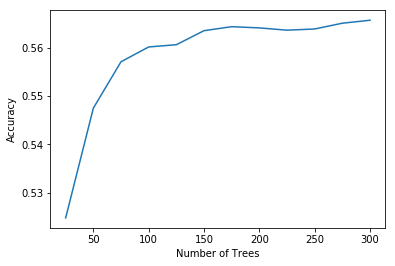

In [50]:
# selecting number of trees
error_rate_sqrt = np.array([])
num_trees_sqrt = np.array([])

min_trees = 25
max_trees = 300

clf_sqrt = RandomForestRegressor(warm_start=False, 
                             oob_score=True,
                             max_features="sqrt",
                             random_state = 1)

for i in range(min_trees,max_trees+1, 25):
    clf_sqrt.set_params(n_estimators=i)
    clf_sqrt.fit(X_train, y_train)
    error_rate_sqrt = np.append(error_rate_sqrt,clf_sqrt.oob_score_)
    num_trees_sqrt = np.append(num_trees_sqrt,i)

plt.plot(num_trees_sqrt,error_rate_sqrt);
plt.xlabel('Number of Trees');
plt.ylabel('Accuracy');

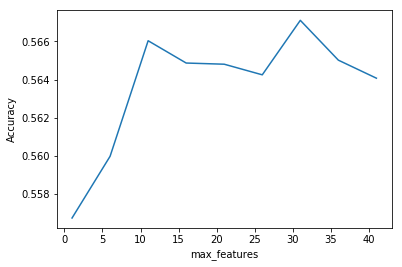

In [52]:
# selecting max_features
error_rate = np.array([])
features = np.array([])

min_features = 1
max_features = 45

clf = RandomForestRegressor(oob_score=True,
                             n_estimators=300,
                             random_state = 1)
for m in range(min_features,max_features+1, 5):
    clf.set_params(max_features=m)
    clf.fit(X_train, y_train)
    error_rate = np.append(error_rate,clf.oob_score_)
    features = np.append(features, m)

plt.plot(features,error_rate);
plt.xlabel('max_features');
plt.ylabel('Accuracy');

In [53]:
# final random forest morel
clf = RandomForestRegressor(oob_score=True,
                             n_estimators=300,
                             max_features = 31)

clf.fit(X_train,y_train)

print('Misclassification rate: ', np.sum((round_half_vect(clf.predict(X_test)) - y_test) != 0)/len(y_test))
print('Testing error: ',np.sum((round_half_vect(clf.predict(X_test)) - y_test)**2)/len(y_test))

Misclassification rate:  0.45297504798464494
Testing error:  0.15834932821497122


In [320]:
# check which departments have the most errors
check = pd.concat([joined_df[['Department','course', 'instructor', 'term', 
                      'rCourseQualityBinned0.5']].iloc[X_test.index].reset_index(drop=True), 
                   pd.DataFrame(clf.predict(X_test))/2], axis=1)

In [186]:
# proportion of misclassified by dept
check[check['rCourseQualityBinned0.5'] - check[0] != 0].groupby('Department').count()['instructor']/joined_df.groupby('Department').count()['course']

Department
ACCT    0.076159
BEPP    0.125628
FNCE    0.096698
HCMG    0.161290
LGST    0.082418
MGMT    0.109228
MKTG    0.102222
OIDD    0.149425
REAL    0.018868
STAT    0.072727
dtype: float64

### Neural Network

In [373]:
# using SKLearn neural network
neural = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 5, 5), random_state=42)
neural.fit(X_train, y_train*2)  
print('Misclassification rate: ', np.sum((neural.predict(X_test)/2 - y_test) != 0)/len(y_test))

Misclassification rate:  0.5239923224568138


In [13]:
# define baseline neural net model
def baseline_model(neurons=1):
    # create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=1916, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [58]:
# fit baseline model
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
estimator.fit(X_train, y_train*2)

print('Misclassification rate ', np.sum((estimator.predict(X_test)/2 - y_test) != 0)/len(y_test))

Instructions for updating:
Use tf.cast instead.
Misclassification rate  0.6928982725527831


In [62]:
# grid search for tuning
# model
model = KerasClassifier(build_fn=baseline_model, batch_size=5, verbose=0)

# parameter grid
batch_size = [10, 20, 40, 60]
epochs = [10, 50, 100]
neurons = [15, 20, 25, 30]
param_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X_train, y_train*2)

print("Best: %f using %s" % (1 - grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.467308 using {'batch_size': 10, 'epochs': 100, 'neurons': 15}
0.482692 (0.010651) with: {'batch_size': 10, 'epochs': 10, 'neurons': 15}
0.497596 (0.015496) with: {'batch_size': 10, 'epochs': 10, 'neurons': 20}
0.489904 (0.006684) with: {'batch_size': 10, 'epochs': 10, 'neurons': 25}
0.487019 (0.018711) with: {'batch_size': 10, 'epochs': 10, 'neurons': 30}
0.498077 (0.006459) with: {'batch_size': 10, 'epochs': 50, 'neurons': 15}
0.505769 (0.002695) with: {'batch_size': 10, 'epochs': 50, 'neurons': 20}
0.506250 (0.014787) with: {'batch_size': 10, 'epochs': 50, 'neurons': 25}
0.495192 (0.015496) with: {'batch_size': 10, 'epochs': 50, 'neurons': 30}
0.532692 (0.022834) with: {'batch_size': 10, 'epochs': 100, 'neurons': 15}
0.507212 (0.015815) with: {'batch_size': 10, 'epochs': 100, 'neurons': 20}
0.503846 (0.017295) with: {'batch_size': 10, 'epochs': 100, 'neurons': 25}
0.511538 (0.022632) with: {'batch_size': 10, 'epochs': 100, 'neurons': 30}
0.480769 (0.029780) with: {'batch_size

In [63]:
# fit model using best params
estimator = KerasClassifier(build_fn=baseline_model, neurons=15, epochs=100, batch_size=10, verbose=0)
estimator.fit(X_train, y_train*2)

print('Misclassification rate ', np.sum((estimator.predict(X_test)/2 - y_test) != 0)/len(y_test))

Misclassification rate  0.46257197696737046


In [54]:
X_train.shape

(2504, 1916)

In [55]:
# define deeper neural net model
def deeper_model():#neurons, layers):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=1916, activation='relu'))
    model.add(Dense(20, input_dim=1916, activation='relu'))
    model.add(Dense(15, input_dim=1916, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [56]:
# fit deeper model
estimator = KerasClassifier(build_fn=deeper_model, epochs=100, batch_size=10, verbose=0)
estimator.fit(X_train, y_train*2)

print('Misclassification rate ', np.sum((estimator.predict(X_test)/2 - y_test) != 0)/len(y_test))

Misclassification rate  0.41467304625199364


In [63]:
np.sum((estimator.predict(X_test)/2 - y_test) != 0)

260

In [61]:
np.sum(np.sqrt((estimator.predict(X_test)/2 - y_test)**2) == 0.5)

221

In [66]:
221/260

0.85

### KNN

In [152]:
max_neighbors = 45
scores = np.array([])
neighbors = np.array([])

for i in range(1, max_neighbors + 1):
    # fit model
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train*2) 

    # model predictions
    score = cross_validate(neigh, X_train, y_train*2, cv=10, scoring='accuracy')
    scores = np.append(scores, np.mean(score.get('test_score')))
    neighbors = np.append(neighbors, i)
    
print('Best: ', neighbors[np.where(scores == max(scores))[0][0]], 'neighbors')

KeyboardInterrupt: 

In [95]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train, y_train*2)
pred_knn = neigh.predict(X_test)

print('Misclassification rate: ', sum((pred_knn/2 - y_test) != 0)/len(y_test))
confusion_matrix(y_test*2, pred_knn)

Misclassification rate:  0.4274322169059011


array([[  1,   3,   1,   0,   0,   0,   0],
       [  2,   7,   9,   0,   1,   0,   0],
       [  5,  10,  71,  24,  11,   0,   0],
       [  2,   9,  37,  89,  45,   5,   0],
       [  0,   0,   8,  50, 124,  14,   0],
       [  0,   0,   0,   8,  19,  59,   1],
       [  0,   0,   0,   0,   0,   4,   8]])

### SVM

In [155]:
scores_svm = np.array([])
c_svm = np.array([])

for i in range(1, 10):
    svc = SVC(C=i, kernel='poly', gamma='auto')
    svc.fit(X_train, y_train*2)
    
    scores = cross_validate(svc, X_train, y_train*2, cv=10, scoring='accuracy')
    scores_svm = np.append(scores_svm, np.mean(scores.get('test_score')))
    c_svm = np.append(c_svm, i)

print('Best: ', c_svm[np.where(scores_svm == max(scores_svm))[0][0]], 'as C')

Best:  9.0 as C


In [36]:
svc = SVC(C=9, kernel='poly', gamma='auto')
svc.fit(X_train, y_train*2)
print('Misclassification rate: ', sum((svc.predict(X_test)/2 - y_test) != 0)/len(y_test))

Misclassification rate:  0.41626794258373206


### Logistic Regression Model

In [130]:
glm = LogisticRegression(multi_class='multinomial', solver='newton-cg')
glm.fit(X_train, y_train*2)
pred_glm = glm.predict(X_test)
print('Misclassification rate: ', sum((pred_glm/2 - y_test) != 0)/len(y_test))

Misclassification rate:  0.4354066985645933


/opt/conda/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


## Using Computed Data

### Logistic Regression Model

In [129]:
glm = LogisticRegression(multi_class='multinomial', solver='newton-cg')
glm.fit(X_computed_train, y_train*2)
pred_glm = glm.predict(X_computed_test)
print('Misclassification rate: ', sum((pred_glm/2 - y_test) != 0)/len(y_test))

Misclassification rate:  0.6012759170653907


### KNN

In [118]:
max_neighbors = 7
k_scores = np.array([])
neighbors_comp = np.array([])

for i in range(1, max_neighbors + 1):
    # fit model
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_computed_train, y_train*2) 

    # model predictions
    scores = cross_validate(neigh, X_computed_train, y_train*2, cv=10, scoring='accuracy')
    k_scores = np.append(k_scores, np.mean(scores.get('test_score')))
    neighbors_comp = np.append(neighbors_comp, i)
    
print('Best: ', neighbors[np.where(k_scores == max(k_scores))[0][0]], 'neighbors')

Best:  1.0 neighbors


In [120]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_computed_train, y_train*2)
pred_knn = neigh.predict(X_computed_test)

print('Misclassification rate: ', sum((pred_knn/2 - y_test) != 0)/len(y_test))
confusion_matrix(y_test*2, pred_knn)

Misclassification rate:  0.43859649122807015


array([[  1,   2,   0,   0,   2,   0,   0],
       [  1,   6,   8,   0,   1,   3,   0],
       [  4,   8,  64,  28,  13,   4,   0],
       [  2,   6,  39,  96,  33,  11,   0],
       [  0,   0,  10,  54, 115,  16,   1],
       [  0,   0,   4,   3,  18,  60,   2],
       [  0,   0,   0,   0,   0,   2,  10]])

### LASSO

In [141]:
lasso = Lasso(fit_intercept=True, normalize=True)
lasso.fit(X_words_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [142]:
sum(lasso.coef_ != 0)

0

In [140]:
y_train

2819    4.0
1459    3.5
2698    2.5
2764    3.5
789     2.5
3023    2.0
1359    3.5
1770    2.5
272     2.0
521     3.0
522     2.5
1659    2.0
2874    2.5
2355    3.0
350     3.0
1003    2.5
1808    2.5
2421    3.0
809     2.5
2708    2.5
2543    3.0
2512    2.0
2631    3.5
1602    3.0
168     2.5
2618    3.0
1509    2.5
2517    2.0
2643    3.0
2500    2.0
       ... 
474     2.0
2904    2.0
747     3.5
2300    3.5
21      2.5
459     2.0
1184    2.5
2324    3.5
955     3.0
1215    3.0
2433    2.5
2853    3.0
1515    2.5
2391    3.0
769     3.0
1685    2.5
130     3.0
2919    2.5
2135    3.5
1482    2.0
330     2.5
1238    2.5
466     3.0
2169    3.5
1638    2.0
3092    2.5
1095    2.0
1130    1.5
1294    2.0
860     3.0
Name: rCourseQualityBinned0.5, Length: 2504, dtype: float64